# Day 3: reduced model 基础作业

In [1]:
import brainpy as bp
import brainpy.math as bm
import numpy as np
import matplotlib.pyplot as plt

## 1. Running a built-in Leaky Integrate-and-Fire (LIF) neuron model

In this section, you can play with the built-in LIF model and use different inputs to determine the minimal current. First, we inject a constant input into the model.

In [34]:
def run_LIF_constant_input():
  # 运行LIF模型

  # TODO: 实例化一个LIF模型
  group = ...

  # TODO: 实例化DSRunner，设置constant input为22.，并monitor变量V
  runner = ...
  runner(200)  # 运行时长为200ms

  # 结果可视化
  fig, gs = bp.visualize.get_figure(1, 1, 4.5, 6)
  ax = fig.add_subplot(gs[0, 0])
  plt.plot(runner.mon.ts, runner.mon.V)
  plt.xlabel(r'$t$ (ms)')
  plt.ylabel(r'$V$ (mV)')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

  plt.show()

  0%|          | 0/2000 [00:00<?, ?it/s]

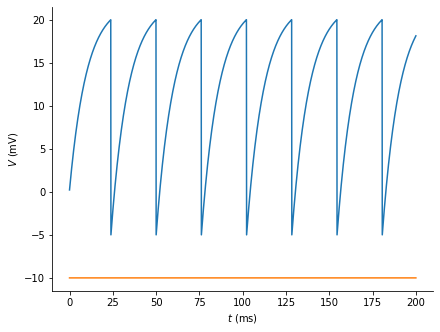

In [35]:
run_LIF_constant_input()

Next, you can try to find the rheobase current by using section input. 

In [52]:
def run_LIF_section_input():
  # 运行LIF模型

  # TODO: 实现一个section input，并对不用神经元设置不同大小的电流输入，观察神经元的输出，确定rheobase current
  current, length = ...

  group = bp.neurons.LIF(current.shape[1])

  # TODO: 实例化DSRunner，monitor变量V，并传入section input
  runner = ...
  runner(200)  # 运行时长为200ms

  # 结果可视化
  fig, gs = bp.visualize.get_figure(1, 1, 4.5, 6)
  ax = fig.add_subplot(gs[0, 0])
  plt.plot(runner.mon.ts, runner.mon.V)
  plt.xlabel(r'$t$ (ms)')
  plt.ylabel(r'$V$ (mV)')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  plt.show()

  0%|          | 0/2000 [00:00<?, ?it/s]

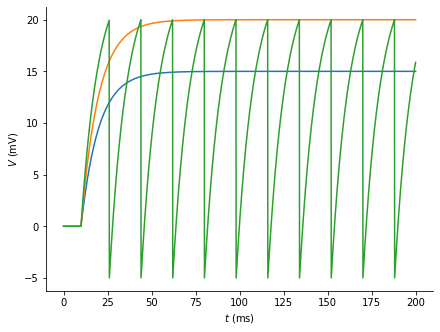

In [53]:
run_LIF_section_input()

## Answer 1

In [54]:
def run_LIF_constant_input():
  # 运行LIF模型

  group = bp.neurons.LIF(1)
  runner = bp.DSRunner(group, monitors=['V'], inputs=('input', 22.))
  runner(200)  # 运行时长为200ms

  # 结果可视化
  fig, gs = bp.visualize.get_figure(1, 1, 4.5, 6)
  ax = fig.add_subplot(gs[0, 0])
  plt.plot(runner.mon.ts, runner.mon.V)
  plt.xlabel(r'$t$ (ms)')
  plt.ylabel(r'$V$ (mV)')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

  plt.show()

  0%|          | 0/2000 [00:00<?, ?it/s]

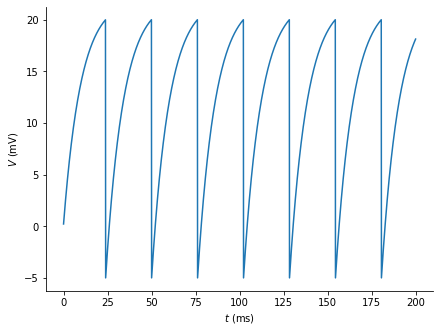

In [55]:
run_LIF_constant_input()

In [11]:
def run_LIF_section_input():
  # 运行LIF模型
  current, length = bp.inputs.section_input(values=[0., bm.asarray([15., 20., 25.]), 0.],
                                            durations=[10, 200, 10],
                                            return_length=True)
  print('current shape:', current.shape)
  print('current.shape[1]', current.shape[1])

  group = bp.neurons.LIF(current.shape[1])
  runner = bp.DSRunner(group, monitors=['V'], inputs=('input', current, 'iter'))
  runner(200)  # 运行时长为200ms

  # 结果可视化
  fig, gs = bp.visualize.get_figure(1, 1, 4.5, 6)
  ax = fig.add_subplot(gs[0, 0])
  plt.plot(runner.mon.ts, runner.mon.V)
  plt.xlabel(r'$t$ (ms)')
  plt.ylabel(r'$V$ (mV)')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  plt.show()

current shape: (2200, 3)
current.shape[1] 3


  0%|          | 0/2000 [00:00<?, ?it/s]

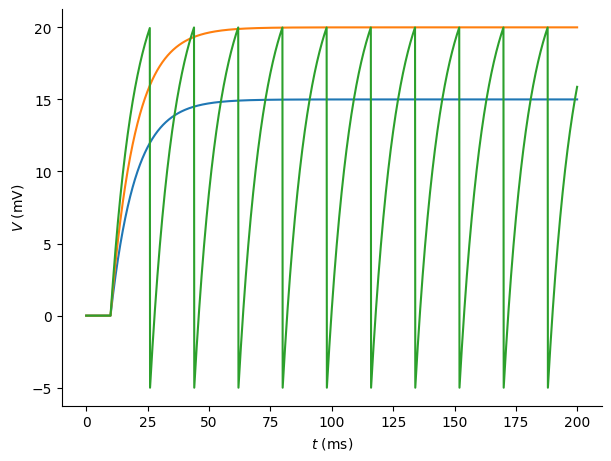

In [12]:
run_LIF_section_input()

## 2. Running a built-in AdEx neuron model

You can try different parameters combinations and observe the firing pattern.

In [13]:
def run_AdEx():
  # 运行AdEx模型
  param_dict = {
    'V_rest': -70.,
    'V_reset': -55.,
    'V_th': -30.,
    'V_T': -50.,
    'delta_T': 2.,
    'a': 0.01,
    'b': 60.,
    'R': .5,
    'tau': 20.,
    'tau_w': 30.
  }
  # 可以尝试的参数组合包括但不限于：
  # a        0.01, 0.01, 0.5,  -0.5, 1.,   -1.
  # b        60.,  5.,   7.,   7.,   10.,  5.
  # tau      20.,  20.,  5.,   5.,   10.,  5.
  # tau_w    30.,  100., 100., 100., 100., 100.
  # V_reset  -55., -55., -51., -47., -60., -60.
  # Iext     65.,  65.,  65.,  65.,  55.,  25.
  group = bp.neurons.AdExIF(10, **param_dict)
  runner = bp.DSRunner(group, monitors=['V', 'w'], inputs=('input', 65.))
  runner(300)
  bp.visualize.line_plot(runner.mon.ts, runner.mon.V, legend='V', show=False)
  bp.visualize.line_plot(runner.mon.ts, runner.mon.w, legend='w', show=True)

  0%|          | 0/3000 [00:00<?, ?it/s]

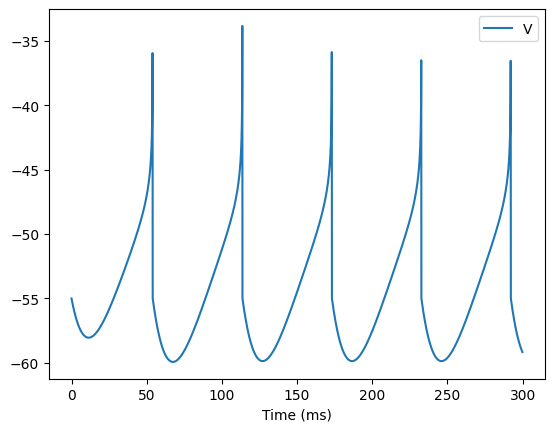

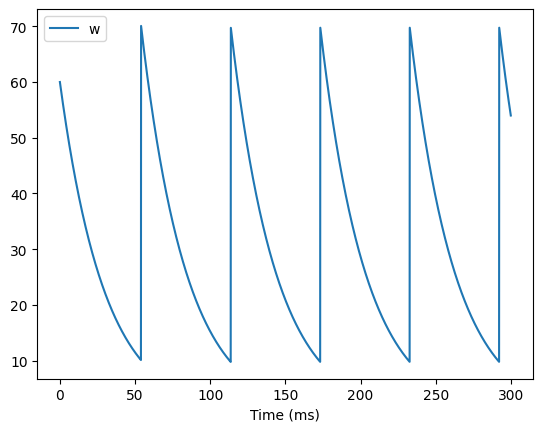

In [14]:
run_AdEx()